In [1]:
from utils import import_data, clean_values
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


path = './data/Data for technical assessment.xlsx'
top_x_percent_threshold = 0.7

data_general, data_underwritings = import_data(path)

replacing_values = {}
# cleaning up this one quite aggressivly as assuming, that if any of these numbers would be an actual one, we would know this independently of the given report...
temp = 0.15*1e6
replacing_values['SCR coverage ratio'] = f'>{temp}'

data_general = clean_values(data_general, replacing_values)

replacing_values = {}
# cleaning up this one quite aggressively as assuming, that if any of these numbers would be an actual one, we would know this independently of the given report...
temp = 0.25*1e6
replacing_values['Gross expense ratio'] = f'>{temp}'
temp = 12000
replacing_values['Gross combined ratio'] = f'>{temp}'
temp = 0.25*1e6
replacing_values['Net expense ratio'] = f'>{temp}'
temp = 0.25*1e6
replacing_values['Net combined ratio'] = f'>{temp}'
temp = 0.25*1e6
replacing_values['Pure net claims ratio'] = f'>{temp}'
temp = 0.25*1e6
replacing_values['Pure gross claims ratio'] = f'>{temp}'

data_underwritings = clean_values(data_underwritings, replacing_values)

replacing_values = {}
temp = -2000
replacing_values['Gross expense ratio'] = f'<{temp}'
temp = -10000
replacing_values['Gross combined ratio'] = f'<{temp}'
temp = -2000
replacing_values['Net expense ratio'] = f'<{temp}'
temp = -10000
replacing_values['Net combined ratio'] = f'<{temp}'
temp = -10000
replacing_values['Pure net claims ratio'] = f'<{temp}'
temp = -10000
replacing_values['Pure gross claims ratio'] = f'<{temp}'
data_underwritings = clean_values(data_underwritings, replacing_values)

C:\Users\Hanne\programming\BoE006191\utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[i] = np.nanmean(data[i])
C:\Users\Hanne\programming\BoE006191\utils.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[i] = np.nanmean(data[i])


<Figure size 1440x1440 with 0 Axes>

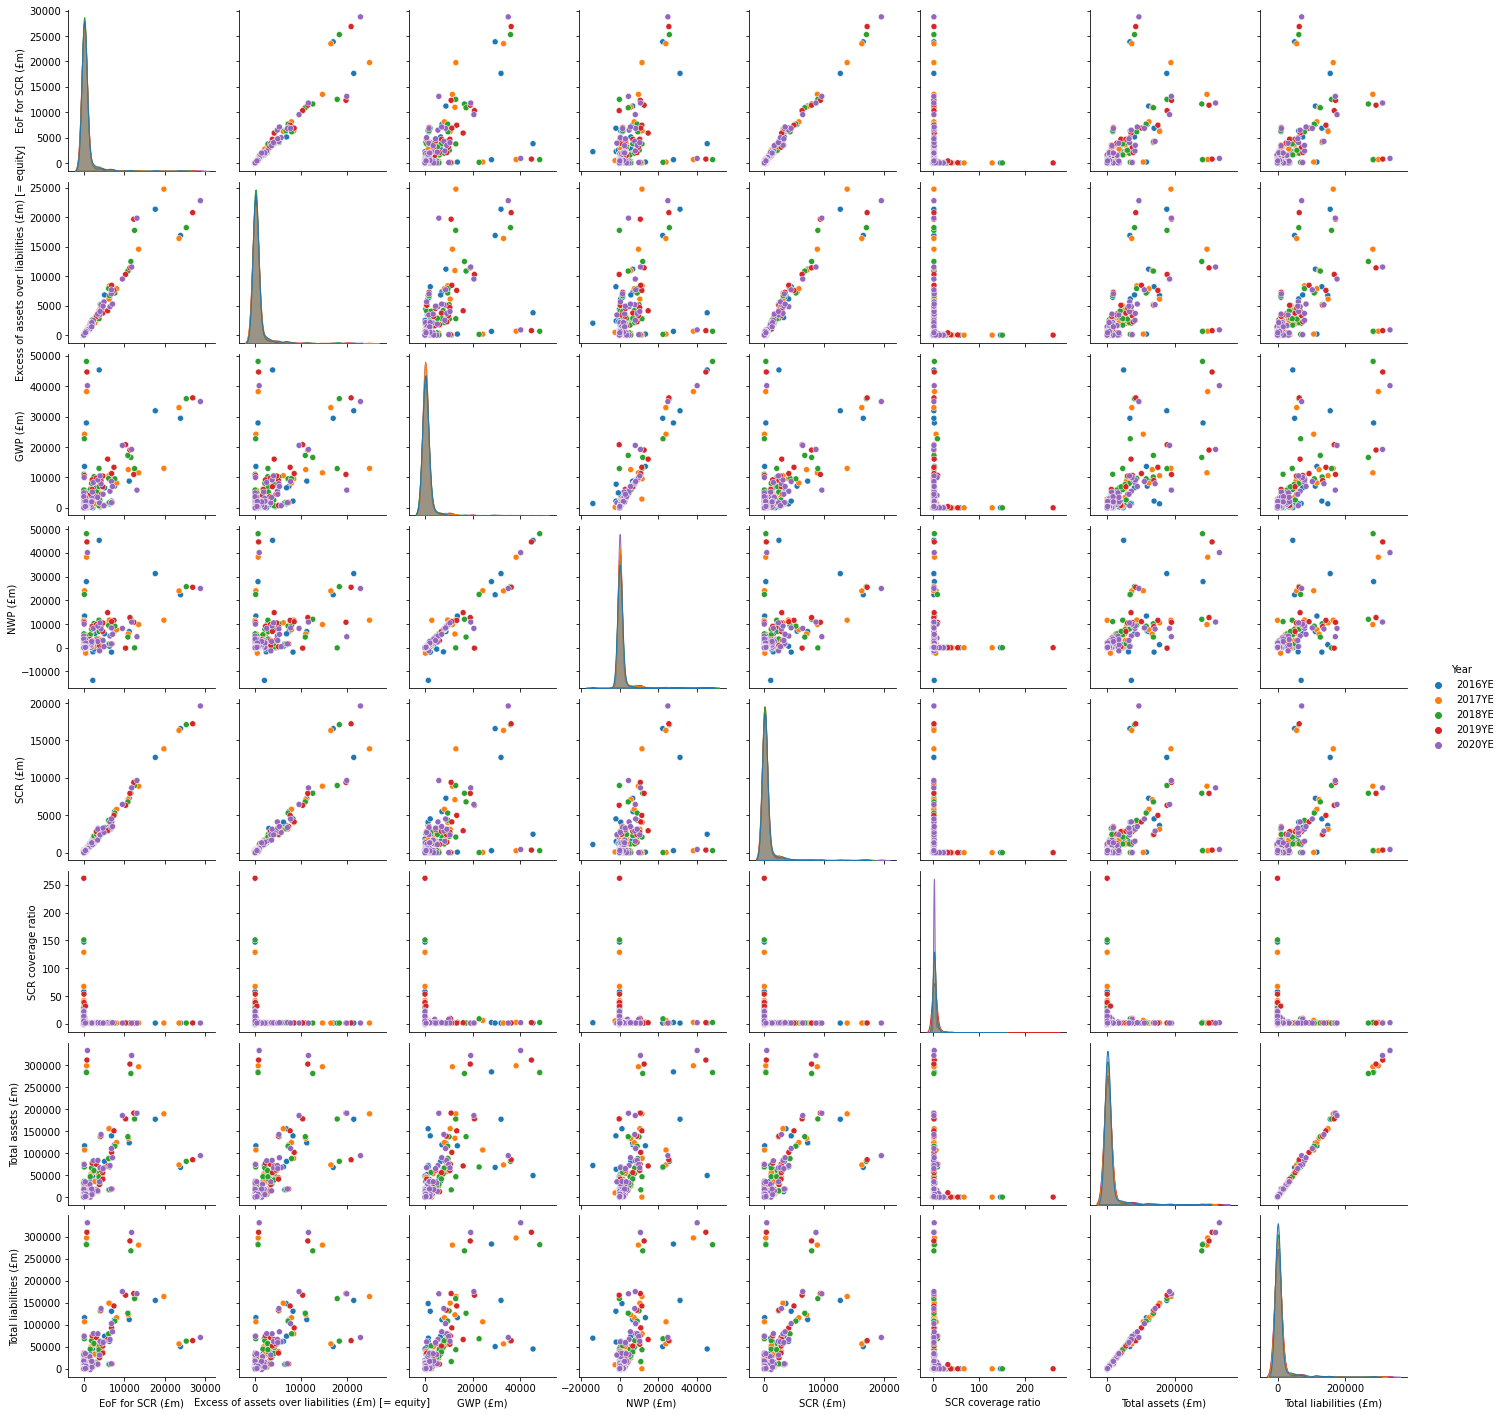

<Figure size 1440x1440 with 0 Axes>

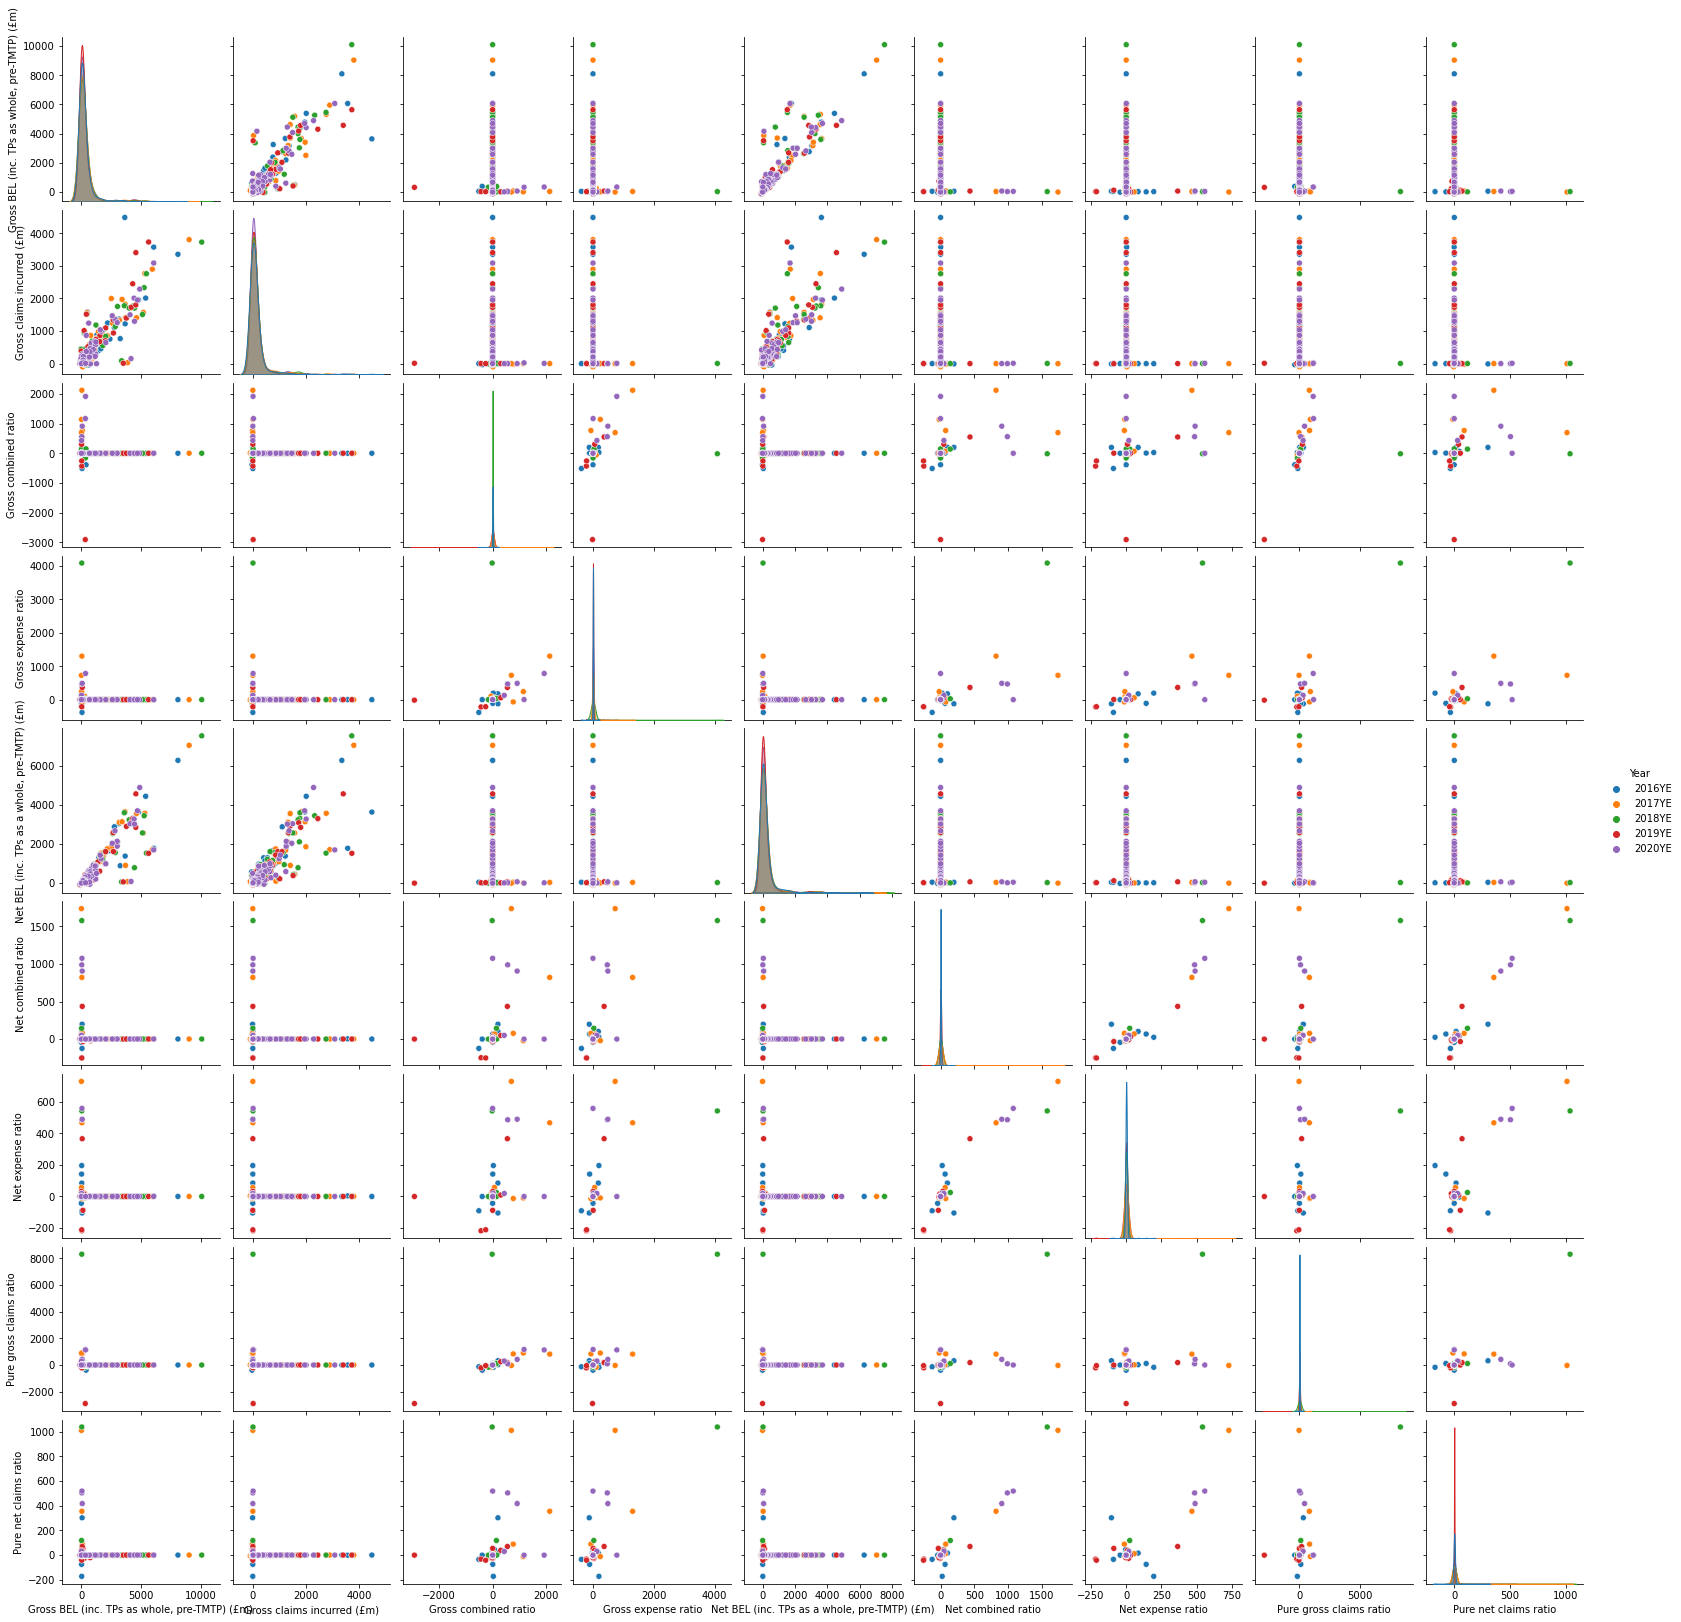

In [2]:
# Making some easy plots first to get a quick overview about possible outliers, distributions, ...
plt.figure(figsize=(20, 20))
sns.pairplot(data=data_general.reset_index(), hue="Year")
plt.show()
# 2017 seems to be show re-occuring outliers

plt.figure(figsize=(20, 20))
sns.pairplot(data=data_underwritings.reset_index(), hue="Year")
plt.show()

In order to identify the most important insurance companies w.r.t. their size, following the typical ABC-Analysis, the Top X important companies are chosen

C:\Users\Hanne\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


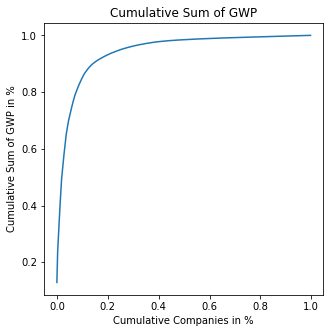

In [3]:
# cleaning up now in order to take only the top X% important companies -> ABC analysis
data_general_top_gwp_filtered = data_general.unstack().T
companies_gwp_per_year = data_general_top_gwp_filtered.loc[('GWP (£m)', slice(None)), :]
# in order to avoid negative values later on and to avoid dividing by 0
companies_gwp_per_year = companies_gwp_per_year + np.abs(np.min(companies_gwp_per_year)) * 1.001
data_general_top_gwp_filtered_sum_per_year = companies_gwp_per_year.sum(axis=0)

for i in companies_gwp_per_year.columns:
    companies_gwp_per_year[i] = companies_gwp_per_year[i] / data_general_top_gwp_filtered_sum_per_year.loc[i]

avg_gwp = pd.DataFrame(companies_gwp_per_year.mean(axis=1), columns=['GWP Percentage Of All'])
avg_gwp = avg_gwp.sort_values('GWP Percentage Of All', ascending=False)

# todo change here
avg_gwp['CumSum'] = avg_gwp.cumsum()

companies_to_be_analysed_based_on_size = list(avg_gwp[avg_gwp['CumSum'] <= (1 - top_x_percent_threshold)].index.get_level_values(level='Company'))

avg_gwp = avg_gwp.reset_index()
avg_gwp['Company'] = [i / avg_gwp.shape[0] for i in range(avg_gwp.shape[0])]

# plotting now also the given ABC analysis
plt.figure(figsize=(5, 5))
sns.lineplot(data=avg_gwp, x='Company', y='CumSum')
plt.title('Cumulative Sum of GWP')
plt.xlabel("Cumulative Companies in %")
plt.ylabel("Cumulative Sum of GWP in %")
plt.show()

Analysing now the NWP

C:\Users\Hanne\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


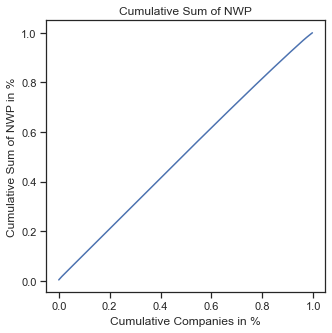

In [33]:
# cleaning up now in order to take only the top X% important companies -> ABC analysis
data_general_top_gwp_filtered = data_general.unstack().T
companies_gwp_per_year = data_general_top_gwp_filtered.loc[('NWP (£m) ', slice(None)), :]
companies_gwp_per_year_index = companies_gwp_per_year.index
companies_gwp_per_year_columns = companies_gwp_per_year.columns
companies_gwp_per_year = companies_gwp_per_year.values / data_general_top_gwp_filtered.loc[('GWP (£m)', slice(None)), :].values
companies_gwp_per_year = pd.DataFrame(companies_gwp_per_year, index=companies_gwp_per_year_index, columns=companies_gwp_per_year_columns)

# in order to avoid negative values later on and to avoid dividing by 0
companies_gwp_per_year = companies_gwp_per_year + np.abs(np.min(companies_gwp_per_year)) * 1.001
data_general_top_gwp_filtered_sum_per_year = companies_gwp_per_year.sum(axis=0)

for i in companies_gwp_per_year.columns:
    companies_gwp_per_year[i] = companies_gwp_per_year[i] / data_general_top_gwp_filtered_sum_per_year.loc[i]

avg_gwp = pd.DataFrame(companies_gwp_per_year.mean(axis=1), columns=['NWP Percentage Of All'])
avg_gwp = avg_gwp.sort_values('NWP Percentage Of All', ascending=False)

# todo change here
avg_gwp['CumSum'] = avg_gwp.cumsum()

companies_to_be_analysed_based_on_size = list(avg_gwp[avg_gwp['CumSum'] <= (1 - top_x_percent_threshold)].index.get_level_values(level='Company'))

avg_gwp = avg_gwp.reset_index()
avg_gwp['Company'] = [i / avg_gwp.shape[0] for i in range(avg_gwp.shape[0])]

# plotting now also the given ABC analysis
plt.figure(figsize=(5, 5))
sns.lineplot(data=avg_gwp, x='Company', y='CumSum')
plt.title('Cumulative Sum of NWP')
plt.xlabel("Cumulative Companies in %")
plt.ylabel("Cumulative Sum of NWP in %")
plt.show()

SCR coverage ratio

In [48]:
# cleaning up now in order to take only the top X% important companies -> ABC analysis
data_general_top_gwp_filtered = data_general.unstack().T
companies_gwp_per_year = data_general_top_gwp_filtered.loc[('SCR coverage ratio', slice(None)), '2020YE'].sort_values()
print(companies_gwp_per_year[companies_gwp_per_year < 1][companies_gwp_per_year > 0.01])
print(companies_gwp_per_year[companies_gwp_per_year < 1.1][companies_gwp_per_year > 1])


Metrics             Company 
SCR coverage ratio  Firm 213    0.692150
                    Firm 148    0.963584
Name: 2020YE, dtype: float64
Metrics             Company 
SCR coverage ratio  Firm 296    1.014180
                    Firm 199    1.066503
                    Firm 100    1.077108
Name: 2020YE, dtype: float64


Net combined ratio

In [58]:
# cleaning up now in order to take only the top X% important companies -> ABC analysis
data_general_top_gwp_filtered = data_underwritings.unstack().T
companies_gwp_per_year = data_general_top_gwp_filtered.loc[('Net combined ratio', slice(None)), '2020YE'].sort_values()
print(companies_gwp_per_year[companies_gwp_per_year > 1].sort_values(ascending=False).head(5))


Metrics             Company 
Net combined ratio  Firm 228    1076.158703
                    Firm 166     989.155405
                    Firm 284     906.307872
                    Firm 72       49.511434
                    Firm 178      21.003690
Name: 2020YE, dtype: float64


Now, we are going to analyse potential business profile changes

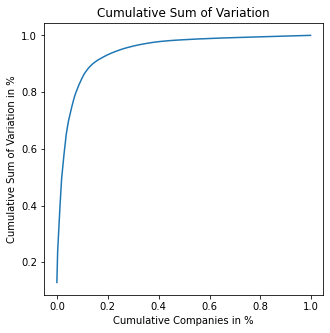

In [4]:
change_rates_general = data_general / data_general.groupby(level='Company').shift(1)
change_rates_general = change_rates_general.dropna()
change_rates_underlying = data_general / data_general.groupby(level='Company').shift(1)
change_rates_underlying = change_rates_underlying.dropna()

outlier_based = change_rates_general.groupby(level='Company').std().mean(axis=1).sort_values(ascending=False).head(5).index

companies_to_be_analysed = pd.DataFrame(change_rates_general.groupby(level='Company').rolling(2).std()).loc[(slice(None), '2020YE', slice(None)), :].mean(axis=1).sort_values(ascending=False)
companies_to_be_analysed.index.names = ['Company', 'Year', 'Temp']
companies_to_be_analysed = pd.DataFrame(companies_to_be_analysed.droplevel(level=['Year', 'Temp']))
companies_to_be_analysed.columns = ['Variation']
#companies_to_be_analysed = companies_to_be_analysed.drop(index=['Firm 320', 'Firm 276'])
companies_to_be_analysed['CumSum'] = companies_to_be_analysed['Variation'] / np.sum(companies_to_be_analysed['Variation'])
companies_to_be_analysed['CumSum'] = companies_to_be_analysed['CumSum'].cumsum()
outlier_based = companies_to_be_analysed.head(5).index
companies_to_be_analysed_to_show = 1 - companies_to_be_analysed['CumSum']

# plotting now also the given ABC analysis
companies_to_be_analysed = avg_gwp.reset_index()
companies_to_be_analysed['Company'] = [i / companies_to_be_analysed.shape[0] for i in range(companies_to_be_analysed.shape[0])]
# plotting now also the given ABC analysis
plt.figure(figsize=(5, 5))
sns.lineplot(data=companies_to_be_analysed, x='Company', y='CumSum')
plt.title('Cumulative Sum of Variation')
plt.xlabel("Cumulative Companies in %")
plt.ylabel("Cumulative Sum of Variation in %")
plt.show()

Taking now a look on further possible machine learning applications for clustering

<Figure size 360x360 with 0 Axes>

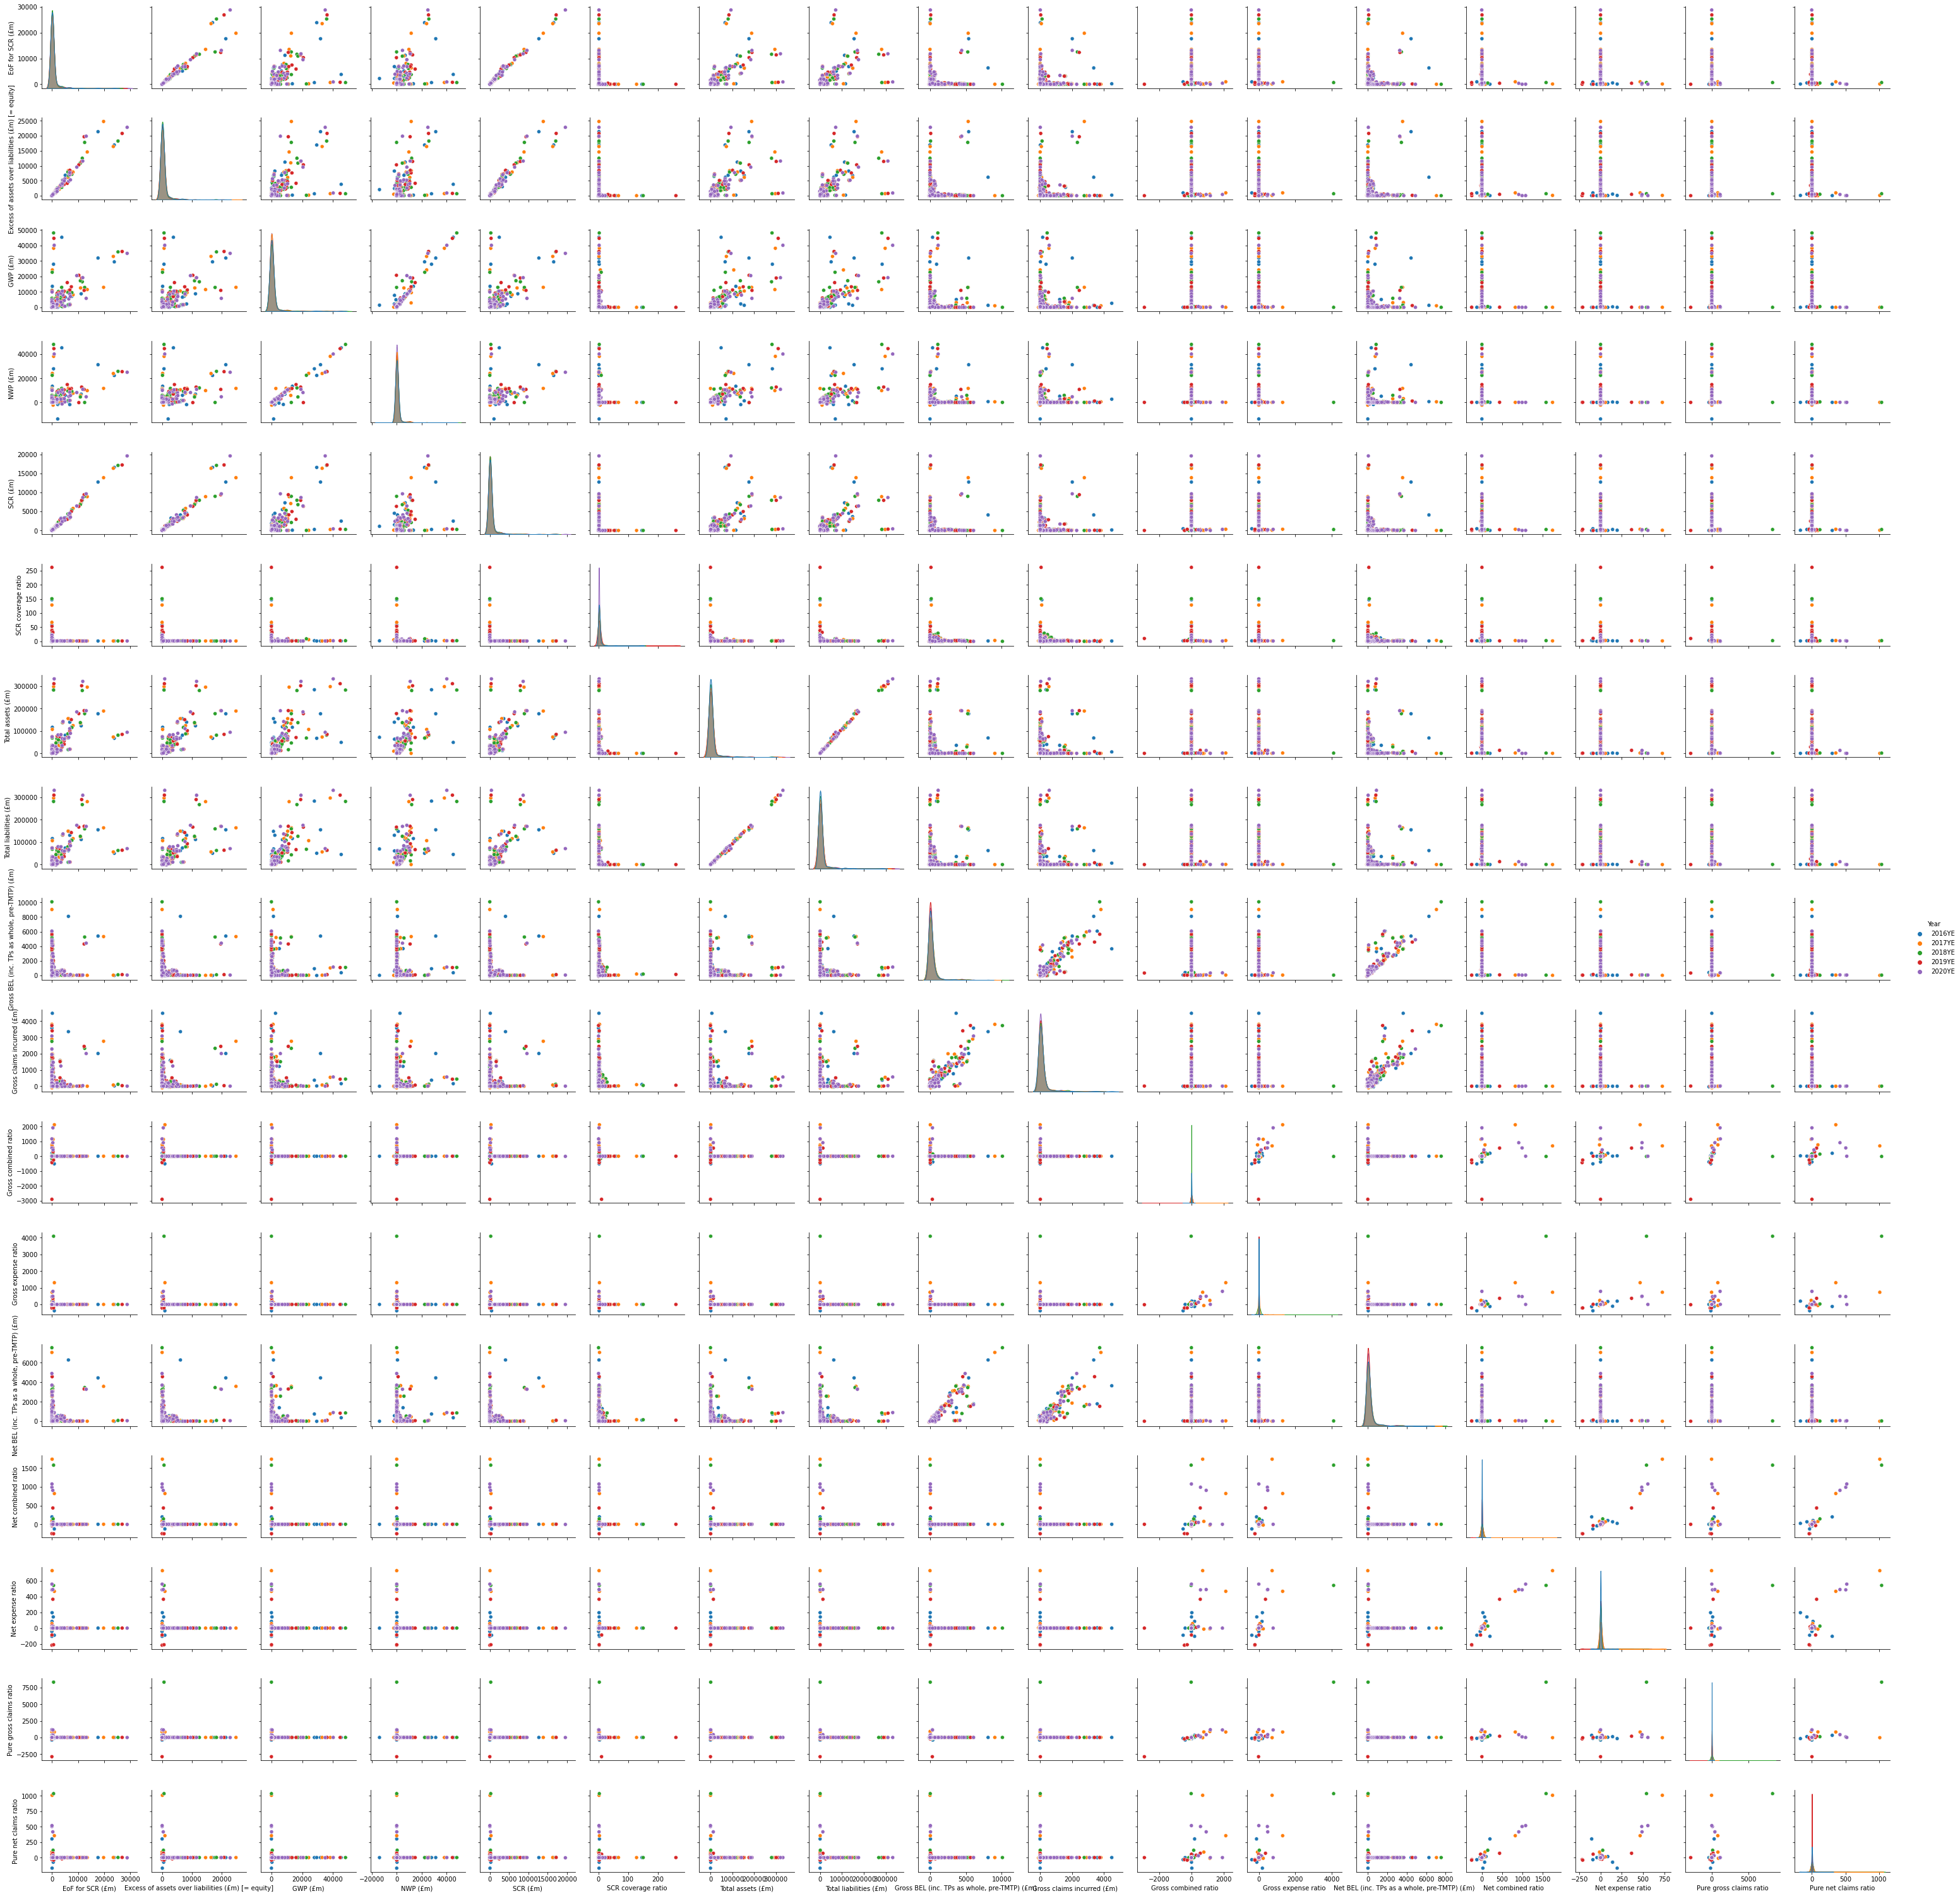

<Figure size 360x360 with 0 Axes>

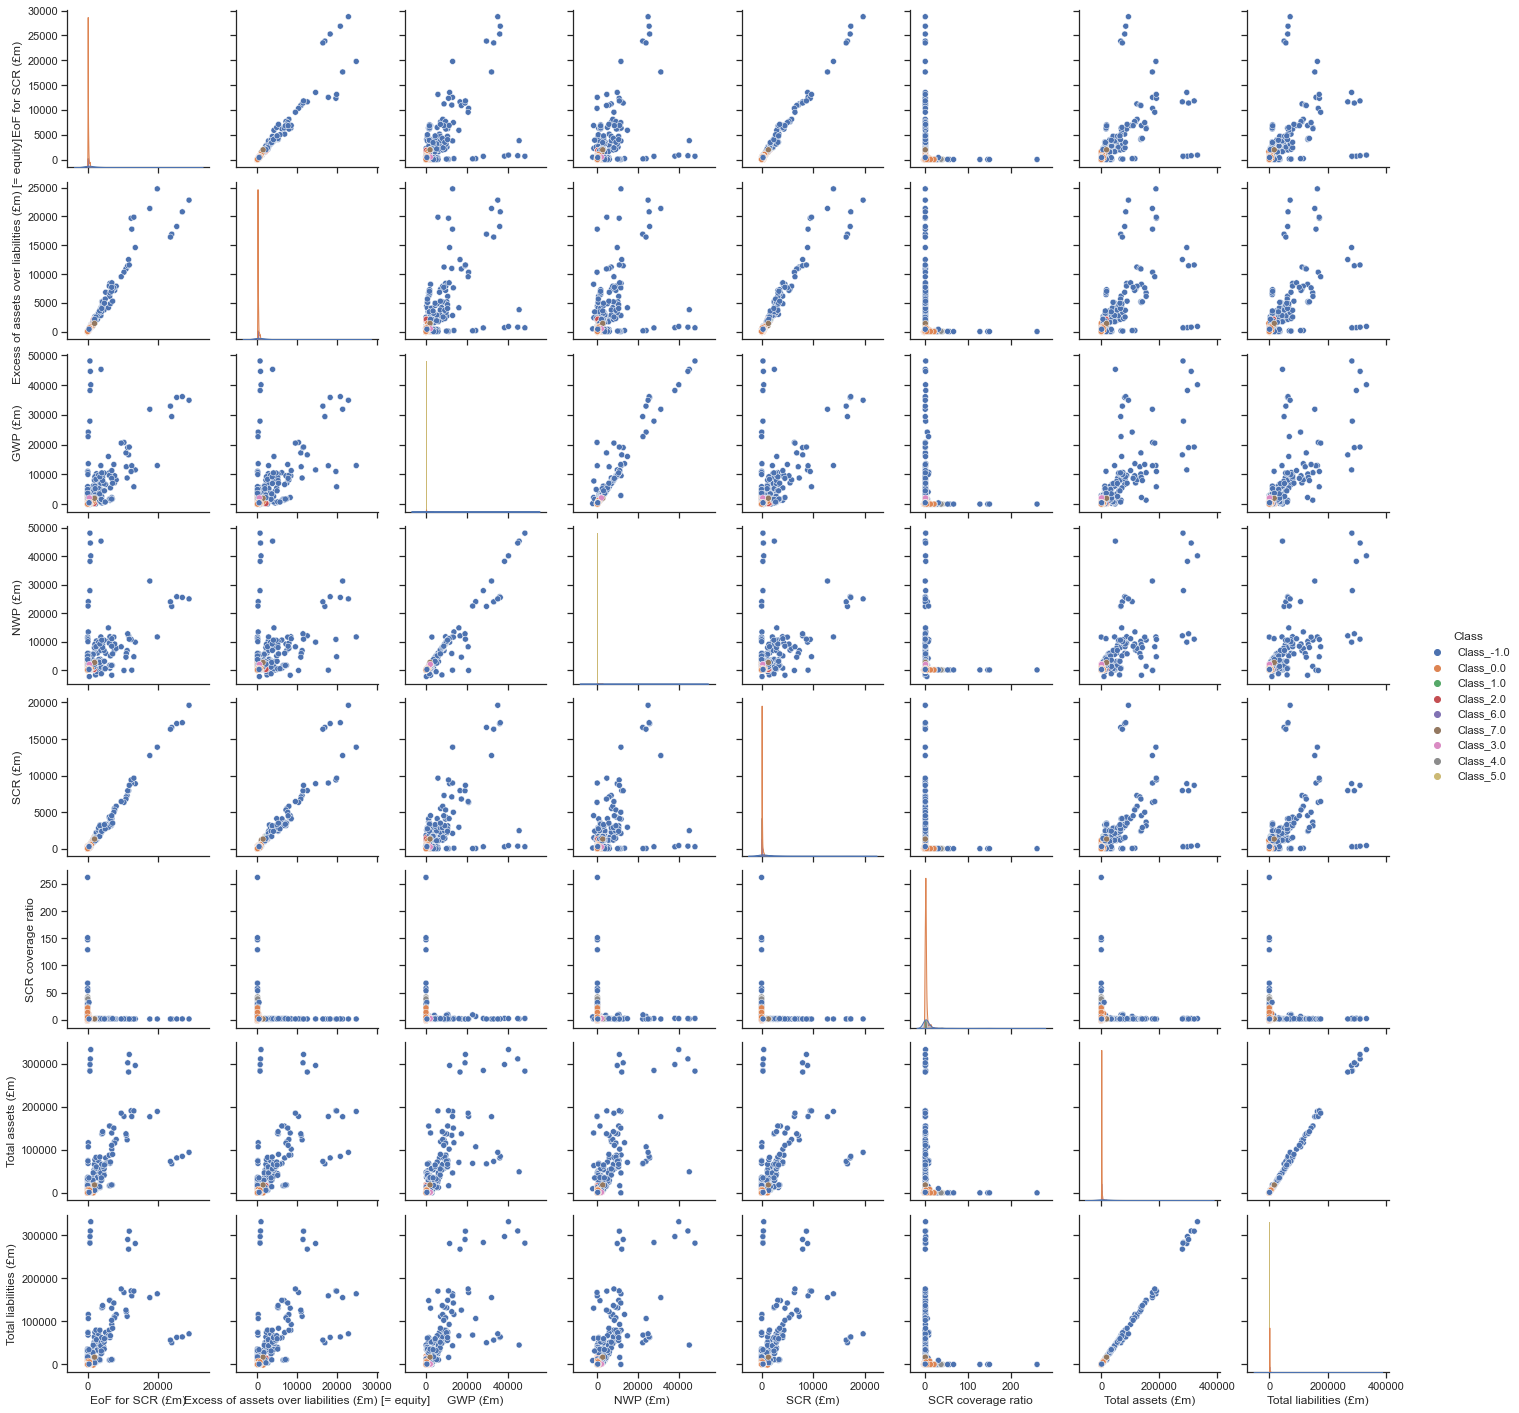

In [5]:
merged_data = data_general.copy().join(data_underwritings)

plt.figure(figsize=(5, 5))
sns.pairplot(data=merged_data.reset_index(), hue="Year")
plt.show()

change_rate = merged_data / merged_data.groupby(level='Year').shift(1) - 1
change_rate = change_rate.replace([np.inf, -np.inf], np.nan)
change_rate = change_rate.dropna()
change_rate.columns = change_rate.columns + '_change_rate_t1'
merged_data = merged_data.join(change_rate)

merged_data_scaled = pd.DataFrame(StandardScaler().fit_transform(merged_data), index=merged_data.index, columns=merged_data.columns)
merged_data_scaled = merged_data_scaled.replace([np.inf, -np.inf], np.nan)
merged_data_scaled = merged_data_scaled.dropna()

clustering = DBSCAN(n_jobs=-1)

clustering_predictions = clustering.fit_predict(merged_data_scaled)
clustering_predictions = pd.DataFrame(clustering_predictions, index=merged_data_scaled.index, columns=['Class'])
clustering_predictions = clustering_predictions.replace(0, 0.1)

clustering_predictions_2020 = pd.DataFrame(clustering_predictions.loc[('2020YE', slice(None)), 'Class'], columns=['Class']).dropna()

single_companies_per_class = clustering_predictions_2020[clustering_predictions_2020['Class'].isin([2.0, 3.0, 5.0, 6.0, 7.0])]

clustering_predictions = clustering_predictions.replace(0.1, 0)
min_class = np.min(clustering_predictions['Class'])
clustering_predictions['Class'] = clustering_predictions['Class'].apply(lambda x: f'Class_{x}')
sns.set_theme(style="ticks")
merged_data = data_general.join(clustering_predictions)
plt.figure(figsize=(5, 5))
sns.pairplot(data=merged_data.reset_index(), hue="Class")
plt.show()

Change of clustering during time

In [6]:
merged_data = data_general.copy().join(data_underwritings)

change_rate = merged_data / merged_data.groupby(level='Year').shift(1) - 1
change_rate = change_rate.replace([np.inf, -np.inf], np.nan)
change_rate = change_rate.dropna()
change_rate.columns = change_rate.columns + '_change_rate_t1'
merged_data = merged_data.join(change_rate)

merged_data_scaled = pd.DataFrame(StandardScaler().fit_transform(merged_data), index=merged_data.index, columns=merged_data.columns)
merged_data_scaled = merged_data_scaled.replace([np.inf, -np.inf], np.nan)
merged_data_scaled = merged_data_scaled.dropna()

clustering = DBSCAN(n_jobs=-1)

clustering_predictions = clustering.fit_predict(merged_data_scaled)
clustering_predictions = pd.DataFrame(clustering_predictions, index=merged_data_scaled.index, columns=['Class'])
clustering_predictions = clustering_predictions.replace(0, 0.1)
clustering_predictions_changes = clustering_predictions / clustering_predictions.groupby(level='Company').shift(1) - 1
clustering_predictions_changes = clustering_predictions_changes[clustering_predictions_changes != 0]

# obviously, the change rate itself is not of interest at all, as it just shows, that the class has changed. It just helps to identify non-changes
clustering_predictions_changes_2020 = pd.DataFrame(clustering_predictions_changes.loc[('2020YE', slice(None)), :]).dropna()

clustering_predictions_changes_2020_companies = clustering_predictions_changes_2020[clustering_predictions_changes_2020['Class'] != -1.1][clustering_predictions_changes_2020['Class'] != -11].index.get_level_values(level='Company')

print(clustering_predictions.loc[(['2019YE', '2020YE'], clustering_predictions_changes_2020_companies), :])


                 Class
Year   Company        
2019YE Firm 107    1.0
       Firm 278    5.0
       Firm 319    4.0
       Firm 323    4.0
2020YE Firm 107   -1.0
       Firm 278   -1.0
       Firm 319    0.1
       Firm 323    0.1


<ipython-input-6-c7dca9a8c12e>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clustering_predictions_changes_2020_companies = clustering_predictions_changes_2020[clustering_predictions_changes_2020['Class'] != -1.1][clustering_predictions_changes_2020['Class'] != -11].index.get_level_values(level='Company')
